## TODO

- Usare stesso Target e feature di Interpolazione
- Window e Target Size fissi - Così dovrebbe bastare una fully connected layer
- Guardare come si allenano i transformers
- Creare account Wandb

In [1]:
import torch
from torch.utils.data import DataLoader, Dataset, SequentialSampler
import pandas as pd

In [2]:
class CustomDataset(Dataset):
    TARGET_MASK_ID = 1
    FEATURES_MASK_ID = 0
    DAY_IN_MINUTES = 287
    
    EXCLUDE_FEATURES = [
        "Failure", "Frequency", "Status", "Others",
        "Code", "name", "deviceid", "serial",
        "SB0", "Phase", "NV10P", "TotalEnergy_QuotControl", 
        #"INV01_TotalEnergy", "INV02_TotalEnergy", "INV03_TotalEnergy",
        #"cos",
        #"sin",
        "state", "SOL", "NA16", 'soil_moisture_7_to_28cm (m³/m³)',
    ]
    
    def __init__(self, dataset_path, window=6, target_size=1, start_date='2022-06-01', end_date='2023-04-01', verbose=False):
        self.df = pd.read_csv(dataset_path, delimiter = ";")
        self.df['timestamp'] = pd.to_datetime(self.df['timestamp'], yearfirst=True)
        cols_to_remove = [column  for column in self.df.columns if len([elem for elem in self.EXCLUDE_FEATURES if elem in column]) > 0]
        self.df = self.df.drop(columns=cols_to_remove)
        
        # filtro per le date contenute nel range start_date < x < end_date
        self.df = self.df[self.df['timestamp'] > pd.to_datetime('2022-06-01')]
        self.df = self.df[self.df['timestamp'] < pd.to_datetime('2023-04-01')]
        
        self.window = window
        self.target_size = target_size # numero di giorni da interpolare
        self.shape = self.df.shape
        self.verbose = verbose
        
        if self.verbose:
            # controllo se le colonne hanno dei NaN
            print(self.df.isna().any())

    def __len__(self):
        temp= (self.df.shape[0]/self.DAY_IN_MINUTES)-(2*(self.window) + (self.target_size))-1
        #print("TEMP:", temp)
        #print("DF ROWS:", self.df.shape[0])
        #print("PRE DIFF", (2*(self.window*self.DAY_IN_MINUTES) + (self.target_size*self.DAY_IN_MINUTES)))
        #print((2*(self.window*self.DAY_IN_MINUTES) + (self.target_size*self.DAY_IN_MINUTES)))
        return int(temp)
        #return len(self.df)
    
    def __getitem__(self, idx):
        days = self.df.iloc[0+(idx*self.DAY_IN_MINUTES): self.DAY_IN_MINUTES*(self.window+self.target_size+self.window)+(idx*self.DAY_IN_MINUTES), ~self.df.columns.str.contains('^Unnamed')]
        
        if self.verbose:
            display("Target from dataframe")
            display(days)
                
        days = days[days.columns.drop(list(days.filter(regex='^.*_name.*$')))]
        days = days[days.columns.drop(list(days.filter(regex='^Unnamed')))]
        days['timestamp'] = pd.to_numeric(days['timestamp'])
        
        if self.verbose:
            display("Target after processing")
            display(days)
        
        target = days[self.DAY_IN_MINUTES*self.window:self.DAY_IN_MINUTES*(self.window+self.target_size)]
        target = target['Cont_TotalEnergy(kWh)']
        
        data_left = days[0:self.DAY_IN_MINUTES*self.window]
        data_right = days[self.DAY_IN_MINUTES*(self.window+self.target_size):]
        data = pd.concat([data_left, data_right])
        
        # mask = [self.FEATURES_MASK_ID]*(self.window*self.DAY_IN_MINUTES) + [self.TARGET_MASK_ID]*(self.target_size*self.DAY_IN_MINUTES) + [self.FEATURES_MASK_ID]*(self.window*self.DAY_IN_MINUTES)
        
        #if self.verbose:
        #    display("Mask")
        #    display(mask)
        
        tensor_target = torch.tensor(target.values)
        tensor_target = torch.reshape(tensor_target, (self.target_size*self.DAY_IN_MINUTES, 1))
        tensor_features = torch.tensor(data.values)
        tensor_features = tensor_features[None, :]
        return tensor_target, tensor_features
    
    def set_verbose(self, value: bool):
        self.verbose = value

In [3]:
train_dataset = CustomDataset("merged_annuale_meteo.csv", window=1, verbose=True)

timestamp                          False
INV01_CurrentDC(A)                 False
INV01_CurrentAC(A)                 False
INV01_TotalEnergy(kWh)             False
INV01_PowerAC(kW)                  False
INV01_PowerDC(kW)                  False
INV01_InternalTemperature(C)       False
INV01_HeatSinkTemperature(C)       False
INV01_VoltageDC(V)                 False
INV01_VoltageAC(V)                 False
INV02_CurrentDC(A)                 False
INV02_CurrentAC(A)                 False
INV02_TotalEnergy(kWh)             False
INV02_PowerAC(kW)                  False
INV02_PowerDC(kW)                  False
INV02_InternalTemperature(C)       False
INV02_HeatSinkTemperature(C)       False
INV02_VoltageDC(V)                 False
INV02_VoltageAC(V)                 False
INV03_CurrentDC(A)                 False
INV03_CurrentAC(A)                 False
INV03_TotalEnergy(kWh)             False
INV03_PowerAC(kW)                  False
INV03_PowerDC(kW)                  False
INV03_InternalTe

In [4]:
len(train_dataset)

300

In [5]:
train_dataset[102]

'Target from dataframe'

,timestamp,INV01_CurrentDC(A),INV01_CurrentAC(A),INV01_TotalEnergy(kWh),INV01_PowerAC(kW),INV01_PowerDC(kW),INV01_InternalTemperature(C),INV01_HeatSinkTemperature(C),INV01_VoltageDC(V),INV01_VoltageAC(V),...,month_sin,month_cos,hour_sin,hour_cos,temperature_2m (°C),relativehumidity_2m (%),dewpoint_2m (°C),rain (mm),cloudcover (%),soil_temperature_7_to_28cm (°C)
63427,2022-09-11 00:05:00,0.0,0.0,304554.12,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,-1.836970e-16,0.000000,1.000000,22.0,81.0,18.6,0.0,1.0,26.5
63428,2022-09-11 00:10:00,0.0,0.0,304554.12,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,-1.836970e-16,0.000000,1.000000,22.0,81.0,18.6,0.0,1.0,26.5
63429,2022-09-11 00:15:00,0.0,0.0,304554.12,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,-1.836970e-16,0.000000,1.000000,22.0,81.0,18.6,0.0,1.0,26.5
63430,2022-09-11 00:20:00,0.0,0.0,304554.12,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,-1.836970e-16,0.000000,1.000000,22.0,81.0,18.6,0.0,1.0,26.5
63431,2022-09-11 00:25:00,0.0,0.0,304554.12,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,-1.836970e-16,0.000000,1.000000,22.0,81.0,18.6,0.0,1.0,26.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64283,2022-09-13 23:35:00,0.0,0.0,309823.28,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,-1.836970e-16,-0.258819,0.965926,18.1,63.0,10.9,0.0,0.0,23.9
64284,2022-09-13 23:40:00,0.0,0.0,309823.28,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,-1.836970e-16,-0.258819,0.965926,18.1,63.0,10.9,0.0,0.0,23.9
64285,2022-09-13 23:45:00,0.0,0.0,309823.28,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,-1.836970e-16,-0.258819,0.965926,18.1,63.0,10.9,0.0,0.0,23.9
64286,2022-09-13 23:50:00,0.0,0.0,309823.28,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,-1.836970e-16,-0.258819,0.965926,18.1,63.0,10.9,0.0,0.0,23.9


'Target after processing'

,timestamp,INV01_CurrentDC(A),INV01_CurrentAC(A),INV01_TotalEnergy(kWh),INV01_PowerAC(kW),INV01_PowerDC(kW),INV01_InternalTemperature(C),INV01_HeatSinkTemperature(C),INV01_VoltageDC(V),INV01_VoltageAC(V),...,month_sin,month_cos,hour_sin,hour_cos,temperature_2m (°C),relativehumidity_2m (%),dewpoint_2m (°C),rain (mm),cloudcover (%),soil_temperature_7_to_28cm (°C)
63427,1662854700000000000,0.0,0.0,304554.12,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,-1.836970e-16,0.000000,1.000000,22.0,81.0,18.6,0.0,1.0,26.5
63428,1662855000000000000,0.0,0.0,304554.12,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,-1.836970e-16,0.000000,1.000000,22.0,81.0,18.6,0.0,1.0,26.5
63429,1662855300000000000,0.0,0.0,304554.12,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,-1.836970e-16,0.000000,1.000000,22.0,81.0,18.6,0.0,1.0,26.5
63430,1662855600000000000,0.0,0.0,304554.12,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,-1.836970e-16,0.000000,1.000000,22.0,81.0,18.6,0.0,1.0,26.5
63431,1662855900000000000,0.0,0.0,304554.12,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,-1.836970e-16,0.000000,1.000000,22.0,81.0,18.6,0.0,1.0,26.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64283,1663112100000000000,0.0,0.0,309823.28,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,-1.836970e-16,-0.258819,0.965926,18.1,63.0,10.9,0.0,0.0,23.9
64284,1663112400000000000,0.0,0.0,309823.28,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,-1.836970e-16,-0.258819,0.965926,18.1,63.0,10.9,0.0,0.0,23.9
64285,1663112700000000000,0.0,0.0,309823.28,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,-1.836970e-16,-0.258819,0.965926,18.1,63.0,10.9,0.0,0.0,23.9
64286,1663113000000000000,0.0,0.0,309823.28,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,-1.836970e-16,-0.258819,0.965926,18.1,63.0,10.9,0.0,0.0,23.9


(tensor([[9282532.5000],
         [9282532.5000],
         [9282532.5000],
         [9282532.5000],
         [9282532.5000],
         [9282532.5000],
         [9282532.5000],
         [9282532.5000],
         [9282532.5000],
         [9282532.5000],
         [9282532.5000],
         [9282532.5000],
         [9282532.5000],
         [9282532.5000],
         [9282532.5000],
         [9282532.5000],
         [9282532.5000],
         [9282532.5000],
         [9282532.5000],
         [9282532.5000],
         [9282532.5000],
         [9282532.5000],
         [9282532.5000],
         [9282532.5000],
         [9282532.5000],
         [9282532.5000],
         [9282532.5000],
         [9282532.5000],
         [9282532.5000],
         [9282532.5000],
         [9282532.5000],
         [9282532.5000],
         [9282532.5000],
         [9282532.5000],
         [9282532.5000],
         [9282532.5000],
         [9282532.5000],
         [9282532.5000],
         [9282532.5000],
         [9282532.5000],


In [6]:
train_dataset.set_verbose(False)

In [7]:
target, features = train_dataset[10]

print(target)
print(features)
print(target.shape, features.shape)

tensor([[8851842.0000],
        [8851842.0000],
        [8851842.0000],
        [8851842.0000],
        [8851842.0000],
        [8851842.0000],
        [8851842.0000],
        [8851842.0000],
        [8851842.0000],
        [8851842.0000],
        [8851842.0000],
        [8851842.0000],
        [8851842.0000],
        [8851842.0000],
        [8851842.0000],
        [8851842.0000],
        [8851842.0000],
        [8851842.0000],
        [8851842.0000],
        [8851842.0000],
        [8851842.0000],
        [8851842.0000],
        [8851842.0000],
        [8851842.0000],
        [8851842.0000],
        [8851842.0000],
        [8851842.0000],
        [8851842.0000],
        [8851842.0000],
        [8851842.0000],
        [8851842.0000],
        [8851842.0000],
        [8851842.0000],
        [8851842.0000],
        [8851842.0000],
        [8851842.0000],
        [8851842.0000],
        [8851842.0000],
        [8851842.0000],
        [8851842.0000],
        [8851842.0000],
        [8851842

In [8]:
sempler = SequentialSampler(train_dataset)

In [9]:
train_dataloader = DataLoader(train_dataset, batch_size=5, sampler=sempler, shuffle=False)

In [10]:
train_target, train_mask = next(iter(train_dataloader))

print("Len Target: ", len(train_target))
print("Len Features: ", len(train_mask))
print("Shape Target: ", train_target.shape)
print("Shape Features: ", train_mask.shape)
print()
print(train_target)
print(train_mask)

Len Target:  5
Len Features:  5
Shape Target:  torch.Size([5, 287, 1])
Shape Features:  torch.Size([5, 1, 574, 42])

tensor([[[8807265.0000],
         [8807265.0000],
         [8807265.0000],
         ...,
         [8812624.5000],
         [8812624.5000],
         [8812624.5000]],

        [[8812624.5000],
         [8812624.5000],
         [8812624.5000],
         ...,
         [8817849.0000],
         [8817849.0000],
         [8817849.0000]],

        [[8817849.0000],
         [8817849.0000],
         [8817849.0000],
         ...,
         [8822412.0000],
         [8822412.0000],
         [8822412.0000]],

        [[8822412.0000],
         [8822412.0000],
         [8822412.0000],
         ...,
         [8827083.0000],
         [8827083.0000],
         [8827083.0000]],

        [[8827083.0000],
         [8827083.0000],
         [8827083.0000],
         ...,
         [8832226.5000],
         [8832226.5000],
         [8832226.5000]]], dtype=torch.float64)
tensor([[[[1.6540e+18, 0.0000e+0

In [11]:
# controllo il contenuto del primo elemento del primo Batch
for i in range(len(train_target[0])):
    print(pd.to_datetime(train_target[0][i][0]))
    

1970-01-01 00:00:00.008807265
1970-01-01 00:00:00.008807265
1970-01-01 00:00:00.008807265
1970-01-01 00:00:00.008807265
1970-01-01 00:00:00.008807265
1970-01-01 00:00:00.008807265
1970-01-01 00:00:00.008807265
1970-01-01 00:00:00.008807265
1970-01-01 00:00:00.008807265
1970-01-01 00:00:00.008807265
1970-01-01 00:00:00.008807265
1970-01-01 00:00:00.008807265
1970-01-01 00:00:00.008807265
1970-01-01 00:00:00.008807265
1970-01-01 00:00:00.008807265
1970-01-01 00:00:00.008807265
1970-01-01 00:00:00.008807265
1970-01-01 00:00:00.008807265
1970-01-01 00:00:00.008807265
1970-01-01 00:00:00.008807265
1970-01-01 00:00:00.008807265
1970-01-01 00:00:00.008807265
1970-01-01 00:00:00.008807265
1970-01-01 00:00:00.008807265
1970-01-01 00:00:00.008807265
1970-01-01 00:00:00.008807265
1970-01-01 00:00:00.008807265
1970-01-01 00:00:00.008807265
1970-01-01 00:00:00.008807265
1970-01-01 00:00:00.008807265
1970-01-01 00:00:00.008807265
1970-01-01 00:00:00.008807265
1970-01-01 00:00:00.008807265
1970-01-01

In [12]:
a, b = train_dataset[301]
print(a.shape, b.shape)
print(pd.to_datetime(int(b[0][0][0])))
print(a, b)

torch.Size([287, 1]) torch.Size([1, 574, 42])
2023-03-29 00:05:00
tensor([[9844713.0000],
        [9844713.0000],
        [9844713.0000],
        [9844713.0000],
        [9844713.0000],
        [9844713.0000],
        [9844713.0000],
        [9844713.0000],
        [9844713.0000],
        [9844713.0000],
        [9844713.0000],
        [9844713.0000],
        [9844713.0000],
        [9844713.0000],
        [9844713.0000],
        [9844713.0000],
        [9844713.0000],
        [9844713.0000],
        [9844713.0000],
        [9844713.0000],
        [9844713.0000],
        [9844713.0000],
        [9844713.0000],
        [9844713.0000],
        [9844713.0000],
        [9844713.0000],
        [9844713.0000],
        [9844713.0000],
        [9844713.0000],
        [9844713.0000],
        [9844713.0000],
        [9844713.0000],
        [9844713.0000],
        [9844713.0000],
        [9844713.0000],
        [9844713.0000],
        [9844713.0000],
        [9844713.0000],
        [9844713.0000]

In [13]:
for batch_idx, (target, features) in enumerate(train_dataloader):
    print(batch_idx, target.shape, features.shape)

#batch_index, (data, mask) = next(next(next(next(enumerate(train_dataloader)))))

0 torch.Size([5, 287, 1]) torch.Size([5, 1, 574, 42])
1 torch.Size([5, 287, 1]) torch.Size([5, 1, 574, 42])
2 torch.Size([5, 287, 1]) torch.Size([5, 1, 574, 42])
3 torch.Size([5, 287, 1]) torch.Size([5, 1, 574, 42])
4 torch.Size([5, 287, 1]) torch.Size([5, 1, 574, 42])
5 torch.Size([5, 287, 1]) torch.Size([5, 1, 574, 42])
6 torch.Size([5, 287, 1]) torch.Size([5, 1, 574, 42])
7 torch.Size([5, 287, 1]) torch.Size([5, 1, 574, 42])
8 torch.Size([5, 287, 1]) torch.Size([5, 1, 574, 42])
9 torch.Size([5, 287, 1]) torch.Size([5, 1, 574, 42])
10 torch.Size([5, 287, 1]) torch.Size([5, 1, 574, 42])
11 torch.Size([5, 287, 1]) torch.Size([5, 1, 574, 42])
12 torch.Size([5, 287, 1]) torch.Size([5, 1, 574, 42])
13 torch.Size([5, 287, 1]) torch.Size([5, 1, 574, 42])
14 torch.Size([5, 287, 1]) torch.Size([5, 1, 574, 42])
15 torch.Size([5, 287, 1]) torch.Size([5, 1, 574, 42])
16 torch.Size([5, 287, 1]) torch.Size([5, 1, 574, 42])
17 torch.Size([5, 287, 1]) torch.Size([5, 1, 574, 42])
18 torch.Size([5, 28

In [14]:
print(data.shape)
print(mask.shape)

NameError: name 'data' is not defined

In [ ]:
a,b = train_dataset[29]
print(a.shape, b.shape)

In [ ]:
a,b = train_dataset[29]
print(a.shape, b.shape)

### Model

In [15]:
import torch.nn.functional as F
from torch import nn
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [16]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
# device = "cpu"
print(f"Using {device} device")

Using cuda device


In [17]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # convolution
        self.conv1 = nn.Conv2d(1, 20, 5, dtype=torch.float64)
        self.conv2 = nn.Conv2d(20, 10, 5, dtype=torch.float64)
        self.conv3 = nn.Conv2d(10, 5, 5, dtype=torch.float64)
        self.pool = nn.MaxPool2d(3, 2) # forse stride va tolto (?)
        self.flat = nn.Flatten()
        # fully connected
        self.linear1 = nn.Linear(24108, 100, dtype=torch.float64)
        #self.linear1 = nn.Linear(19600, 100, dtype=torch.float64)
        self.linear2 = nn.Linear(100, 200, dtype=torch.float64)
        self.linear3 = nn.Linear(200, 287, dtype=torch.float64)
        self.droput = nn.Dropout()
        self.reshape = nn.Unflatten(1, (287, 1))

    def forward(self, x):
        #print(x.shape)
        #x = F.relu(self.conv1(x))
        #x = F.relu(self.conv2(x))
        #x = self.pool(F.relu(self.conv3(x)))
        #x.view()
        x = self.flat(x)
        #x = self.droput(x)
        
        x = F.relu(self.linear1(x))
        #x = self.droput(x)
        x = F.relu(self.linear2(x))
        #x = self.droput(x)
        x = self.linear3(x)
        #x = self.droput(x)
        #print(x)
        x = self.reshape(x)
        return x


In [22]:
model = NeuralNetwork().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
print(model)
print(optimizer)

NeuralNetwork(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(10, 5, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=24108, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=200, bias=True)
  (linear3): Linear(in_features=200, out_features=287, bias=True)
  (droput): Dropout(p=0.5, inplace=False)
  (reshape): Unflatten(dim=1, unflattened_size=(287, 1))
)
SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.001
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)


In [23]:
num_epochs=100

In [24]:
model.train()
t_loss_list, v_loss_list = [], []

for epoch in tqdm(range(num_epochs), unit="epoch"):    
    for batch_idx, (target, features) in enumerate(train_dataloader):
        target, features = target.to(device), features.to(device)
        
        train_probs = model(features)
        #print('Model resu: ', train_probs.shape)
        #print(features.shape, target.shape)
        #print(train_probs[0])
        #print(features)
        #print('Target : ', target.shape)

        #target = target[0:, None, None]
        #train_loss = F.mse_loss(target, train_probs)
        train_loss = F.mse_loss(target, train_probs)
        #train_loss = F.binary_cross_entropy(train_probs, labels.view(train_probs.shape))
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        t_loss_list.append(train_loss.item())
        
    print(
            f"Epoch {epoch+1:02d}/{num_epochs:02d}"
            f" | Train Loss {train_loss:.3f}"
        )

  0%|          | 0/100 [00:00<?, ?epoch/s]

Epoch 01/100 | Train Loss nan
Epoch 02/100 | Train Loss nan
Epoch 03/100 | Train Loss nan
Epoch 04/100 | Train Loss nan
Epoch 05/100 | Train Loss nan


KeyboardInterrupt: 

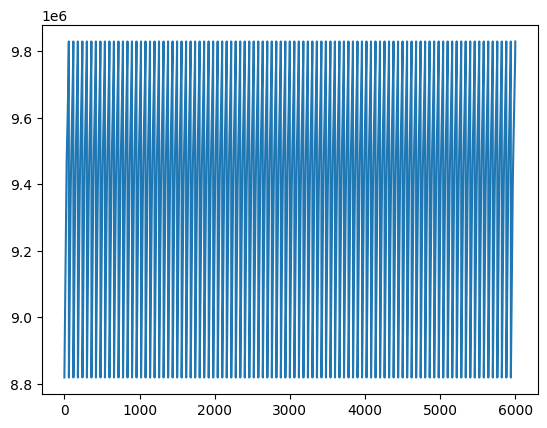

In [100]:
plt.plot(t_loss_list)

In [31]:
torch.cuda.empty_cache()
target = None
features = None
t_loss_list = None
train_probs = None
train_loss = None
model = None
torch.cuda.empty_cache()

In [30]:
import gc

model.cpu()
# del model, checkpoint
del model
gc.collect()
torch.cuda.empty_cache()

## WanDB

In [1]:
import wandb
import random

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="my-awesome-project",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.02,
    "architecture": "CNN",
    "dataset": "CIFAR-100",
    "epochs": 10,
    }
)

# simulate training
epochs = 10
offset = random.random() / 5
for epoch in range(2, epochs):
    acc = 1 - 2 ** -epoch - random.random() / epoch - offset
    loss = 2 ** -epoch + random.random() / epoch + offset
    
    # log metrics to wandb
    wandb.log({"acc": acc, "loss": loss})
    
# [optional] finish the wandb run, necessary in notebooks
wandb.finish()

wandb: Currently logged in as: nicolo-vescera (rofilopd). Use `wandb login --relogin` to force relogin


acc,▁▂▅▅▇█▇█
loss,▆█▇▅▄▁▁▁
acc,0.79953
loss,0.19777


✔✓